# Capstone Project - Training center location selection
### Applied Data Science Capstone by IBM/Coursera

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium.plugins import HeatMap

from bs4 import BeautifulSoup
import html5lib

import pickle

print('Libraries imported.')

Libraries imported.


In [2]:
CLIENT_ID = 'TWQNBUQDQIII1KZJ0RTLFNG0NR15AVJIZU5KFPHM3ANEHMHU' # Foursquare ID
CLIENT_SECRET = 'VD0GO1D1LCR1T5GYDJHBVXS4REOQD4KVWSADZAZGKXOAQ1DU' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Getting latitude and longitude of Montreal

In [3]:
address = 'Montreal'

geolocator = Nominatim(user_agent="mtl_explorer")
location = geolocator.geocode(address)
latitude_mtl = location.latitude
longitude_mtl = location.longitude

## Search for Gym/Fitness venue categories in the Montreal area: 

In [4]:
# Will the data be loaded from local files or built up through Foursquare:
load = False # (1:yes, 0:no)

In [5]:
gym_fitness = '4bf58dd8d48988d175941735' # Root id for all fitness and training facilities

categoryId = {'Boxing Gym':'52f2ab2ebcbc57f1066b8b47', 'Gym': '4bf58dd8d48988d176941735', 'Martial Arts School': '4bf58dd8d48988d101941735', 'Outdoor Gym': '58daa1558bbb0b01f18ec203'} # Category IDs for Boxing Gyms, Gyms, Martial Arts Dojos and outdoor gyms

radius = 26000 # Radius in which to search relative to the center of Montreal
LIMIT = 10000 # Limit of the number of venues to fetch

In [6]:
gym_df = pd.DataFrame()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

if not load:
    # Loop over the different category ids and search for the corresponding venues in the montreal area. Data will be stored in the gym_df dataframe:
    for key_cat in categoryId:
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_mtl, longitude_mtl, VERSION, categoryId[key_cat], radius, LIMIT)

        results = requests.get(url).json()

        # assign relevant part of JSON to venues
        venues = results['response']['venues']

        # tranform venues into a dataframe
        dataframe = json_normalize(venues)

        # keep only columns that include venue name, and anything that is associated with location
        filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
        dataframe_filtered = dataframe.loc[:, filtered_columns]

        # filter the category for each row
        dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

        # clean column names by keeping only last term
        dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

        gym_df = gym_df.append(dataframe_filtered)

    gym_df.drop_duplicates(subset='id', keep="last", inplace= True)
    gym_df.head()

In [7]:
# This will run when we want to load the file locally instead of goign through foursquare:
if load:
    with open('./Gym_dataframe.pkl', 'rb') as f:
        gym_df = pickle.load(f) 
gym_df.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,UnderDog Boxing Gym,Boxing Gym,9 Ste-Catherine East,St-Laurent,45.510055,-73.563710,"[{'label': 'display', 'lat': 45.51005460345811...",3910,Ca,CA,Montréal,QC,Canada,"[9 Ste-Catherine East (St-Laurent), Montréal Q...",NaN,4b6f9c10f964a520c6f72ce3
1,Club de Boxe de d'Est,Boxing Gym,2350 Rue Dickson,NaN,45.567281,-73.537101,"[{'label': 'display', 'lat': 45.56728097321409...",9668,H1N 3T1,CA,Montréal,QC,Canada,"[2350 Rue Dickson, Montréal QC H1N 3T1, Canada]",NaN,5241fdde11d28e28a9ad23c1
2,Club de boxe Titan,Boxing Gym,6777 rue Saint-André,NaN,45.538636,-73.607155,"[{'label': 'display', 'lat': 45.53863644534114...",4617,H2S 2L1,CA,Montréal,QC,Canada,"[6777 rue Saint-André, Montréal QC H2S 2L1, Ca...",NaN,4cfd91a920fe3704236260f8
3,Muay Thai,Boxing Gym,NaN,NaN,45.500788,-73.424580,"[{'label': 'display', 'lat': 45.500788, 'lng':...",14501,NaN,CA,NaN,NaN,Canada,[Canada],NaN,589cfde6e7f1cf49872a982d
4,apex,Boxing Gym,1827 St-Catherine W.,St-Marc,45.493524,-73.580149,"[{'label': 'display', 'lat': 45.493524, 'lng':...",2393,H3H 1M8,CA,Montréal,QC,Canada,"[1827 St-Catherine W. (St-Marc), Montréal QC H...",NaN,54ee76b3498ecc627d1df2a3


In [8]:
# Looking at the different venue categories obtained:
print('The querry fetched the following categories:')
for cat in gym_df['categories'].unique():
    print('- {}'.format(cat))

The querry fetched the following categories:
- Boxing Gym
- Gym
- Gym / Fitness Center
- Climbing Gym
- Residential Building (Apartment / Condo)
- Martial Arts School
- Gym Pool


In [9]:
# Making the categories more uniform:
gym_df.replace(to_replace = 'Gym / Fitness Center', value = 'Gym', inplace= True)

# Dropping dataframe rows that have a category that is non relevant for us:
for cat in gym_df['categories'].unique():
    if cat in categoryId.keys():
        pass
    else:
        gym_df = gym_df[gym_df['categories']!=cat]

# Looking at the different venue categories obtained:
print('The querry fetched the following categories:')
for cat in gym_df['categories'].unique():
    print('- {}'.format(cat))

The querry fetched the following categories:
- Boxing Gym
- Gym
- Martial Arts School


In [10]:
if not load:
    gym_df.to_pickle('./Gym_dataframe.pkl')

Text(0, 0.5, 'Frequency')

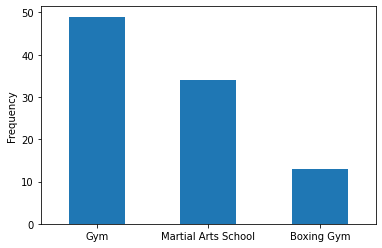

In [11]:
# Plot the frequency of each category:
gym_df['categories'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=0)
plt.ylabel('Frequency')

In [12]:
# Color map to asociate a color for each category venue:
venue_colormap = {
    'Boxing Gym':'red', 
    'Gym': 'blue', 
    'Martial Arts School': 'black',
    'Outdoor Gym': 'yellow'
}

In [13]:
mtl_map = folium.Map(location=[latitude_mtl, longitude_mtl], zoom_start=11)
for lat, lon, name, cat in zip(gym_df['lat'],gym_df['lng'], gym_df['name'], gym_df['categories']):
    label = '{}, ({})'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    try:
        color=venue_colormap[cat]
    except:
        color='grey'
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color = color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(mtl_map)

mtl_map

In [14]:
# Let us plot a heat map to better see the concentration of the trainings:
gym_latlng = [[lat,lng] for lat, lng in zip(list(gym_df['lat']),list(gym_df['lng']))]

mtl_heatmap = folium.Map(location=[latitude_mtl, longitude_mtl], zoom_start=11)
folium.TileLayer('cartodbpositron').add_to(mtl_heatmap) #cartodbpositron cartodbdark_matter
HeatMap(gym_latlng).add_to(mtl_heatmap)
mtl_heatmap

## Nearby venues exploration for each gym:

The purpose of this section is as follows :
* Explore the venues around each gym.
* Fetch the ratings and  likes count of each gym.
* Analyse if there is a correlation between the succes and popularity of a training center and the distance relative to specific types of venues.

### Data wrangling and exploratory data analysis:

In [15]:
# This will run when we want to load the file locally instead of goign through foursquare:
if load:
    with open('./Gym_venues_and_rating.pkl', 'rb') as f:
        gym_venues_df = pickle.load(f)
    gym_venues_df.head()

In [16]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

In [17]:
# We define a function that regroups all the steps required to explore a specific venue (get its rating and likes count) as well as get its nearby venues:
# Inputs:
# - gym_name: Name of the gym/fitness center (string)
# - gym_cat: Category under which the training center falls into (string) 
# - venue_id: The id of the gym/training center (string)
# - gym_lat: latitude of the training center (float)
# - gym_lng: longitude of the training center (float)

# Outputs:
# nearby_venues: DataFrame containing the nearby venues of the gym specified as input

def explore_gym_nearby_venues(gym_name, gym_cat, venue_id, gym_lat, gym_lng):

    gym_venues_radius = 500 # We limit the radius of the search to 500m around the training center
    gym_venues_LIMIT = 300 # We limit the nearby venues to 300

    # Setting the url used to explore a specific venue using the venue's id - the goal is to get the rating and likes count:
    gym_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

    gym_results = requests.get(gym_url).json()

    # Assign relevant part of JSON to venues
    venue = gym_results['response']

    # Tranform venues into a dataframe
    dataframe = json_normalize(venue)

    # Getting the rating and likes count of the venue:
    try:
        likes_count= gym_results['response']['venue']['likes']['count']
        # likes_count = dataframe['venue.likes.count'][0]
    except:
        likes_count = -1
        # likes_count = dataframe['venue.likes.count'][0]

    try:
        rating = gym_results['response']['venue']['rating']
        # rating = dataframe['venue.rating'][0]
    except:
        rating = -1
    
    # Setting the url used to explore nearby venues of the training center:
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, gym_lat, gym_lng, VERSION, gym_venues_radius, gym_venues_LIMIT)
    
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues)
    

    nearby_venues = nearby_venues[filtered_columns]
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type,axis=1)

    nearby_venues.columns = map(str.title,[col_name.split('.')[-1] for col_name in nearby_venues.columns])

    nearby_venues.rename(columns={'Name':'Venue Name'}, inplace=True)

    nearby_venues['Gym Name'] = gym_name
    nearby_venues['Gym category'] = gym_cat
    nearby_venues['Gym id'] = venue_id
    nearby_venues['Gym lat'] = gym_lat
    nearby_venues['Gym lng'] = gym_lng
    nearby_venues['Likes count'] = likes_count
    nearby_venues['Rating'] = rating
    print(' .', end='')

    return nearby_venues

In [59]:
if not load:
    # Building the dataframe containing the training centers, their likes count and rating as well as the nearby venues for each training center:
    gym_venues_df = pd.DataFrame()

    for gym_name, gym_cat, gym_id, gym_lat, gym_lng in zip(gym_df['name'], gym_df['categories'], gym_df['id'], gym_df['lat'], gym_df['lng']):
        nearby_venues = explore_gym_nearby_venues(gym_name, gym_cat, gym_id, gym_lat, gym_lng)
        gym_venues_df = gym_venues_df.append(nearby_venues)
    print(' done.')

    # Reordering the dataframe for better readability:
    column_order = list(gym_venues_df.columns[-7:]) + list(gym_venues_df.columns[:-7])
    gym_venues_df = gym_venues_df[column_order]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


In [60]:
gym_venues_df.head()

,Gym Name,Gym category,Gym id,Gym lat,Gym lng,Likes count,Rating,Venue Name,Categories,Lat,Lng
0,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,Cadet,Restaurant,45.510260,-73.564584
1,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,Bouillon Bilk,Restaurant,45.510845,-73.566017
2,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,Société des arts technologiques [SAT],Music Venue,45.509369,-73.562654
3,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,Cachitos,Bakery,45.509814,-73.564077
4,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,La Maison Symphonique de Montréal,Concert Hall,45.509442,-73.566599


In [61]:
# Due to the limit of 500 premium API calls, let us save the dataframe in order to use it instead of having to use Foursquare.
if not load:
    gym_venues_df.to_pickle('./Gym_venues_and_rating.pkl')

In [62]:
print('The total number of training centers found in the Montreal area is: {} gyms'.format(len(gym_venues_df['Gym id'].unique())))

The total number of training centers found in the Montreal area is: 96 gyms


In [63]:
# Let us see the most common venue category that are found nearby the training centers (we look at all the training centers together):
categories_count = gym_venues_df.groupby('Categories').count().sort_values(by='Gym Name', ascending= False)[['Gym Name']]
categories_count.rename(columns={'Gym Name':'Frequency'}, inplace=True)
categories_count.head(25)

,Frequency
Categories,
Café,152
Coffee Shop,131
Restaurant,95
Hotel,78
French Restaurant,65
Bakery,65
Italian Restaurant,64
Sandwich Place,61
Pizza Place,55


In [64]:
# Uncomment to see the number of nearby venues found for each training centers:
nearby_venues_count = gym_venues_df.groupby('Gym id').count().sort_values(by='Gym Name', ascending= False)[['Gym Name']]
nearby_venues_count.rename(columns={'Gym Name':'Number of nearby venues'}, inplace=True)
nearby_venues_count.head(10)

,Number of nearby venues
Gym id,
4f80bf117bebb2e5d3d80743,100
4cdad31a6ad1a093fc7be856,100
4ae47814f964a520c49a21e3,100
4b701dacf964a520c5072de3,100
5a9eaa8aa9fe123ead2a1b4d,100
50f1e1b4e4b067e9ee937823,95
525d6076498ed004aa99834c,94
50a19bb2498efdffc88c2a4d,86
4b2d1304f964a520bdcd24e3,85


In [65]:
gym_venues_df.shape

(2905, 11)

### Plotting Rating/Likes Count/Succes metric versus disctances to specific venues

In [66]:
def normalize(data):
    return (data - data.min())/(data.max() - data.min())

In [67]:
# Function used to compute distances between two latitude and longitude coordinates:

# Inputs:
# - lat1: latitude of first location (float)
# - lon1: longitude of first location (float)
# - lat2: latitude of second location (float)
# - lon1: longitude of second location (float)

# Outputs:
# - distance (float)

def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371 # Earth's radius
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [68]:
# Function that computes the distance between each gym and all the venues that belong to the venue category specified:
# Inputs:
# - cat: venue category to be analyses (string)
# - gym_venues_df: dataframe containing the gyms/training centers and their corresponding nearby venues (pandas dataFrame)

# Outputs:
# - specific_venue_dist: dataframe containing Gym Name, Gym id, rating of the gym, likes count of the gym, Popularity metric of the gym, distance between the gym and all the nearby venues under the category specified. (DataFrame)
# - norm_likes: Weights for likes count to be used in the bubble plot (Pandas Series)

def gym_venue_dist(venue_category,gym_venues_df):
    # venue_category: Choose a specific venue to use during the analysis of the effect of distance on the rating:
    
    # Selecting only the specifi type of venues category of interest:
    specific_venue = gym_venues_df[gym_venues_df['Categories'] == venue_category]

    # Removing training centers for which no rating & likes count are available:
    specific_venue = specific_venue[specific_venue['Rating']!=-1]
    specific_venue = specific_venue[specific_venue['Likes count']!=0].reset_index()

    # Weights for likes count to be used in the bubble plot:
    norm_likes =(specific_venue['Likes count'] - specific_venue['Likes count'].min())/(specific_venue['Likes count'].max() - specific_venue['Likes count'].min())

    # Building a dataframe with a rating column and distance column (distance between the training center and the venues belonging to the specific category of interest)
    columns = ['Gym Name', 'Gym id','Rating', 'Likes count', 'Pop metric', 'Distance']
    specific_venue_dist= pd.DataFrame(columns=columns)
    for index, row in specific_venue.iterrows():
        dist = haversine_distance(row['Gym lat'], row['Gym lng'], row['Lat'], row['Lng'])
        # if dist !=0:
        specific_venue_dist.loc[index] = [row['Gym Name'],row['Gym id'],row['Rating'],float(row['Likes count']),row['Rating']*float(row['Likes count']),dist]
    
    specific_venue_dist['Rating'] = normalize(specific_venue_dist['Rating'])
    specific_venue_dist['Likes count'] = normalize(specific_venue_dist['Likes count'])
    specific_venue_dist['Pop metric'] = normalize(specific_venue_dist['Pop metric'])
    
    return specific_venue_dist, norm_likes

In [69]:
# Repeating the process in a for loop. For each venue category we compute the average distance between the venues and training centers. We will limit ourselved to the 25 most common venue categories.  
# Then we compute the correlation between ratings, likes count, pop(ularity) metric and the avg distance

columns = ['Venue Category', 'Corr.Rating', 'Corr.Likes count', 'Corr.Pop metric']
distance_corr = pd.DataFrame(columns = columns)

for idx, cat in enumerate(list(categories_count.head(25).index)):
    specific_venue_dist = gym_venue_dist(cat, gym_venues_df)[0]

    try:
        specific_venue_avgdist = specific_venue_dist.groupby('Gym id').mean().sort_values(by='Rating', ascending = False)
        corr_matrix = specific_venue_avgdist.corr()
        distance_corr.loc[idx] = [cat,corr_matrix['Distance']['Rating'],corr_matrix['Distance']['Likes count'],corr_matrix['Distance']['Pop metric']]
    except:
        distance_corr.loc[idx] = [cat,None,None,None]
    print(' .', end='')
print(' done.')

. . . . . . . . . . . . . . . . . . . . . . . . . done.


In [70]:
 # We display the correlation of the distance to the 25 most common venue categories with rating, likes count and Pop(ularity) metrics
 distance_corr.sort_values(by='Corr.Pop metric')

,Venue Category,Corr.Rating,Corr.Likes count,Corr.Pop metric
8,Pizza Place,0.271731,-0.694822,-0.681484
20,Asian Restaurant,0.272513,-0.625826,-0.467089
18,Portuguese Restaurant,-0.707687,-0.328950,-0.402140
7,Sandwich Place,-0.168259,-0.290706,-0.313610
15,Pharmacy,-0.187950,-0.235855,-0.259984
5,Bakery,-0.064382,-0.183537,-0.201880
4,French Restaurant,0.120890,-0.162837,-0.184309
13,Gym,-0.103846,-0.162081,-0.165060
21,Clothing Store,0.329882,-0.089151,-0.089261
14,Vietnamese Restaurant,0.070131,-0.075816,-0.057575


In [71]:
# Analyzing a specific venue category that seems promising:

venue_category = 'Grocery Store'
specific_venue_dist, norm_likes = gym_venue_dist(venue_category,gym_venues_df)
specific_venue_dist.head()

,Gym Name,Gym id,Rating,Likes count,Pop metric,Distance
0,Club Atwater,4b250f38f964a520ca6b24e3,0.629630,0.128205,0.130560,0.48
1,Gym du Plateau,4b141cd5f964a520849d23e3,0.592593,0.145299,0.144597,0.17
2,Gym du Plateau,4b141cd5f964a520849d23e3,0.592593,0.145299,0.144597,0.40
3,Nautilus Plus,4ba13fa8f964a520d2a537e3,1.000000,0.111111,0.132831,0.09
4,Nautilus Plus,4ba13fa8f964a520d2a537e3,1.000000,0.111111,0.132831,0.25


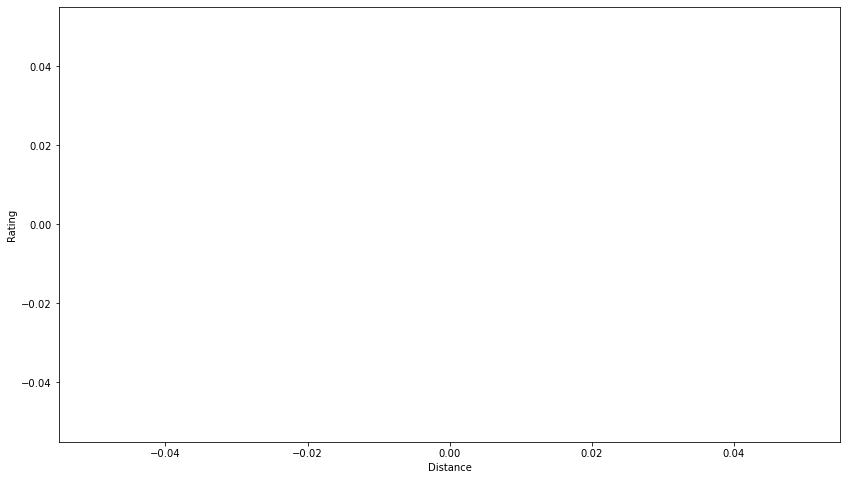

In [30]:
# Plotting the ratings versus the distances to the specific venue category:
specific_venue_dist.plot(kind='scatter',
                    x='Distance',
                    y='Rating',
                    figsize=(14, 8),
                    alpha=0.5, # transparency
                    color='blue',
                    s=norm_likes*2000  + 10  # pass in the weights
                    )

# Comments on the analysis of rating = f(distance):
# - See that the more the distance from other gyms/training centers increases rating increases too.

In [31]:
# The dataframe built contains the distances between the training centers and each of their nearby venues that belong to the category specified.
# We now build a dataframe with the average distance of each training center to this category of nearby venues:
specific_venue_avgdist = specific_venue_dist.groupby('Gym id').mean().sort_values(by='Rating', ascending = False)

# Getting the gym names by order of descending ratings
gym_names = specific_venue_dist.drop_duplicates(subset='Gym id').sort_values(by='Rating', ascending = False)[['Gym Name','Gym id']]
gym_names.set_index('Gym id', drop = True, inplace=True)
gym_names.head()

specific_venue_avgdist = gym_names.join(specific_venue_avgdist)
specific_venue_avgdist.rename(columns={'Distance':"Avg.Distance"}, inplace=True)
specific_venue_avgdist.head(20)

DataError: No numeric types to aggregate

In [32]:
# Plotting the ratings versus the distances to the specific venue category:
specific_venue_avgdist.plot(kind='scatter',
                    x='Avg.Distance',
                    y='Likes count',
                    figsize=(14, 8),
                    alpha=0.5, # transparency
                    color='blue',
                    s = 80
                    )
plt.title('{} venue category correlation analysis'.format(venue_category))


KeyError: 'Avg.Distance'

## One-hot encoding of the nearby venues categories for each Gym:

In [33]:
# One-hot encoding of the nearby venues categories for each Gym:
gym_venues_onehot = pd.get_dummies(gym_venues_df[['Categories']], prefix="", prefix_sep="")
gym_venues_onehot.head()

,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Store,Bistro,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Bus Station,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store,Escape Room,Fast Food Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gas Station,Gastropub,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health Food Store,Hotel,Ice Cream Shop,Indian Restaurant,Indie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mexican Restaurant,Middle Eastern Restaurant,Mongolian Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,Noodle House,Office,Opera House,Paintball Field,Park,Pastry Shop,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plaza,Pool,Portuguese Restaurant,Public Art,Ramen Restaurant,Restaurant,Salvadoran Restaurant,Sandwich Place,Sausage Shop,Shabu-Shabu Restaurant,Shopping Mall,Smoke Shop,Soup Place,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Park Ride / Attraction,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
gym_venues_onehot.shape

(313, 121)

In [35]:
gym_onehot_venues = pd.concat([gym_venues_df[gym_venues_df.columns[:-4]],gym_venues_onehot],axis=1)
# gym_venues_df.columns

In [36]:
gym_onehot_venues.head()

,Venue Name,Categories,Lat,Lng,Gym Name,Gym category,Gym id,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Store,Bistro,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Bus Station,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store,Escape Room,Fast Food Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gas Station,Gastropub,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health Food Store,Hotel,Ice Cream Shop,Indian Restaurant,Indie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mexican Restaurant,Middle Eastern Restaurant,Mongolian Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,Noodle House,Office,Opera House,Paintball Field,Park,Pastry Shop,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plaza,Pool,Portuguese Restaurant,Public Art,Ramen Restaurant,Restaurant,Salvadoran Restaurant,Sandwich Place,Sausage Shop,Shabu-Shabu Restaurant,Shopping Mall,Smoke Shop,Soup Place,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Park Ride / Attraction,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Yoga Studio
0,Cadet,Restaurant,45.510260,-73.564584,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bouillon Bilk,Restaurant,45.510845,-73.566017,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Société des arts technologiques [SAT],Music Venue,45.509369,-73.562654,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Cachitos,Bakery,45.509814,-73.564077,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,La Maison Symphonique de Montréal,Concert Hall,45.509442,-73.566599,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Let's group rows by Gym and by taking the mean of the frequency of occurrence of each category:

In [37]:
gym_venues_grouped = gym_onehot_venues.groupby(gym_onehot_venues['Gym id']).mean().reset_index()
gym_venues_grouped.head()

,Gym id,Lat,Lng,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Store,Bistro,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Bus Station,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store,Escape Room,Fast Food Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gas Station,Gastropub,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health Food Store,Hotel,Ice Cream Shop,Indian Restaurant,Indie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mexican Restaurant,Middle Eastern Restaurant,Mongolian Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,Noodle House,Office,Opera House,Paintball Field,Park,Pastry Shop,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plaza,Pool,Portuguese Restaurant,Public Art,Ramen Restaurant,Restaurant,Salvadoran Restaurant,Sandwich Place,Sausage Shop,Shabu-Shabu Restaurant,Shopping Mall,Smoke Shop,Soup Place,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Park Ride / Attraction,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Yoga Studio
0,4b6f9c10f964a520c6f72ce3,45.508832,-73.562379,0.012821,0.000000,0.064103,0.000000,0.000000,0.000000,0.025641,0.000000,0.012821,0.000000,0.000000,0.012821,0.012821,0.025641,0.000000,0.025641,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.115385,0.000000,0.012821,0.000000,0.012821,0.012821,0.000000,0.051282,0.000000,0.000000,0.012821,0.025641,0.025641,0.000000,0.000000,0.012821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012821,0.025641,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.051282,0.000000,0.000000,0.000000,0.012821,0.000000,0.0,0.0,0.000000,0.012821,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012821,0.038462,0.0,0.012821,0.012821,0.025641,0.000000,0.012821,0.0,0.000000,0.0,0.025641,0.0,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.012821,0.000000,0.038462,0.000000,0.000000,0.000000,0.012821,0.000000,0.0,0.012821,0.000000,0.000000,0.012821,0.000000,0.000000,0.000000,0.012821,0.0,0.012821,0.000000,0.000000,0.000000,0.012821,0.000000,0.089744,0.000000
1,4cfd91a920fe3704236260f8,45.538126,-73.606906,0.000000,0.000000,0.028571,0.000000,0.000000,0.028571,0.028571,0.028571,0.114286,0.028571,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057143,0.000000,0.000000,0.000000,0.000000,0.057143,0.057143,0.000000,0.000000,0.028571,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.028571,0.000000,0.0,0.0,0.028571,0.000000,0.0,0.028571,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.028571,0.028571,0.028571,0.028571,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.028571,0.000000,0.000000,0.028571,0.028571,0.000000,0.0,0.028571,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000
2,4d36e42d4754f04dd62e9e7e,45.483728,-73.797719,0.000000,0.017857,0.017857,0.000000,0.017857,0.000000,0.017857,0.00000

In [38]:
# Looking at the shape of the dataframe, we should get as many rows as there are training centers found in the gym_df dataframe:
print('Shape of dataframe {}'.format(gym_venues_grouped.shape))
print('The number of gyms found is: {} gyms'.format(len(gym_venues_df['Gym id'].unique())))

Shape of dataframe (9, 124)
The number of gyms found is: 9 gyms


In [39]:
# Adding a column with the gym names. We have to respect the ascending order of the id.
gym_venues_grouped[['Gym Name', 'Gym category']] = gym_onehot_venues[['Gym Name', 'Gym category', 'Gym id']].sort_values(by='Gym id',ascending=True)[['Gym Name', 'Gym category']].reset_index(drop=True)

# Reordering the columns for better readability
column_order = list(gym_venues_grouped.columns[-2:]) + list(gym_venues_grouped.columns[:-2])
gym_venues_grouped = gym_venues_grouped[column_order]

gym_venues_grouped.head()

,Gym Name,Gym category,Gym id,Lat,Lng,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Store,Bistro,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Bus Station,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store,Escape Room,Fast Food Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gas Station,Gastropub,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health Food Store,Hotel,Ice Cream Shop,Indian Restaurant,Indie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mexican Restaurant,Middle Eastern Restaurant,Mongolian Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,Noodle House,Office,Opera House,Paintball Field,Park,Pastry Shop,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plaza,Pool,Portuguese Restaurant,Public Art,Ramen Restaurant,Restaurant,Salvadoran Restaurant,Sandwich Place,Sausage Shop,Shabu-Shabu Restaurant,Shopping Mall,Smoke Shop,Soup Place,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Park Ride / Attraction,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Yoga Studio
0,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.508832,-73.562379,0.012821,0.000000,0.064103,0.000000,0.000000,0.000000,0.025641,0.000000,0.012821,0.000000,0.000000,0.012821,0.012821,0.025641,0.000000,0.025641,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.115385,0.000000,0.012821,0.000000,0.012821,0.012821,0.000000,0.051282,0.000000,0.000000,0.012821,0.025641,0.025641,0.000000,0.000000,0.012821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012821,0.025641,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.051282,0.000000,0.000000,0.000000,0.012821,0.000000,0.0,0.0,0.000000,0.012821,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012821,0.038462,0.0,0.012821,0.012821,0.025641,0.000000,0.012821,0.0,0.000000,0.0,0.025641,0.0,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.012821,0.000000,0.038462,0.000000,0.000000,0.000000,0.012821,0.000000,0.0,0.012821,0.000000,0.000000,0.012821,0.000000,0.000000,0.000000,0.012821,0.0,0.012821,0.000000,0.000000,0.000000,0.012821,0.000000,0.089744,0.000000
1,UnderDog Boxing Gym,Boxing Gym,4cfd91a920fe3704236260f8,45.538126,-73.606906,0.000000,0.000000,0.028571,0.000000,0.000000,0.028571,0.028571,0.028571,0.114286,0.028571,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057143,0.000000,0.000000,0.000000,0.000000,0.057143,0.057143,0.000000,0.000000,0.028571,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.028571,0.000000,0.0,0.0,0.028571,0.000000,0.0,0.028571,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.028571,0.028571,0.028571,0.028571,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.028571,0.000000,0.000000,0.028571,0.028571,0.000000,0.0,0.028571,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000
2,UnderDog Boxing Gym,Boxing Gym,4

## Clustering the gyms based on their surrounding venues:

In [40]:
gym_venues_clustering = gym_venues_grouped[gym_venues_grouped.columns[7:]]

In [41]:
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(gym_venues_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 6, 1, 0, 1, 4, 1, 2, 3])

In [42]:
print('Count of all lablels: {} label'.format(len(kmeans.labels_))) # Should be equal to the number of gyms
print('The number of gyms found is: {} gyms'.format(len(gym_venues_df['Gym id'].unique())))

Count of all lablels: 9 label
The number of gyms found is: 9 gyms


In [43]:
# Building a dataframe with the gym name, id, latitude, longitude, likes count, rating as well as the newly found cluster label:
gym_clustered = gym_venues_grouped[list(gym_venues_grouped.columns[:7])]

gym_clustered.insert(len(gym_clustered.columns),'Clustering Labels', kmeans.labels_)

gym_clustered.head()

,Gym Name,Gym category,Gym id,Lat,Lng,Art Gallery,Arts & Crafts Store,Clustering Labels
0,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.508832,-73.562379,0.012821,0.000000,5
1,UnderDog Boxing Gym,Boxing Gym,4cfd91a920fe3704236260f8,45.538126,-73.606906,0.000000,0.000000,6
2,UnderDog Boxing Gym,Boxing Gym,4d36e42d4754f04dd62e9e7e,45.483728,-73.797719,0.000000,0.017857,1
3,UnderDog Boxing Gym,Boxing Gym,4d69203882cba093319bd6d8,45.531834,-73.553353,0.000000,0.000000,0
4,UnderDog Boxing Gym,Boxing Gym,51791840e4b0650bb54cbfc1,45.479983,-73.579374,0.013889,0.000000,1


Text(0, 0.5, 'Frequency')

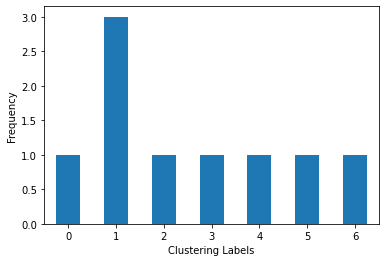

In [44]:
# Look at the size of each cluster:

gym_clustered.groupby('Clustering Labels').count()['Gym Name'].plot(kind = 'bar')
plt.xticks(rotation=0)
plt.ylabel('Frequency')

In [45]:
gym_clustered.groupby('Clustering Labels').count()

,Gym Name,Gym category,Gym id,Lat,Lng,Art Gallery,Arts & Crafts Store
Clustering Labels,,,,,,,
0,1,1,1,1,1,1,1
1,3,3,3,3,3,3,3
2,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1


In [46]:
# Generating montreal map:
mtl_map = folium.Map(location=[latitude_mtl, longitude_mtl], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, name, cat, cluster in zip(gym_clustered['Gym lat'],gym_clustered['Gym lng'], gym_clustered['Gym Name'], gym_clustered['Gym category'], gym_clustered['Clustering Labels']):
    label = '{}, ({})'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    try:
        color=venue_colormap[cat]
    except:
        color='grey'
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color = color, # The border color defines the type of the training center (gym, boxing club, mma, etc ...)
        color_opacity = 0.5,
        fill=True,
        fill_color=rainbow[cluster-1], # The fill color is used to distinguish clusters
        fill_opacity=1,
        parse_html=False).add_to(mtl_map)

mtl_map

KeyError: 'Gym lat'

## Clusters' Analysis :

### Defining features of each cluster - looking at the most common surrounding venues:

In [47]:
# Group by each cluster the nearby venues. Then look at the top 10 most common venues for cluster. 

In [48]:
clusters_grouped = gym_venues_grouped[gym_venues_grouped.columns[7:]]
clusters_grouped.insert(0,'Clustering Labels', kmeans.labels_)

In [49]:
clusters_grouped = clusters_grouped.groupby('Clustering Labels').mean().reset_index()

In [50]:
clusters_grouped

,Clustering Labels,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Store,Bistro,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Bus Station,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store,Escape Room,Fast Food Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gas Station,Gastropub,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health Food Store,Hotel,Ice Cream Shop,Indian Restaurant,Indie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mexican Restaurant,Middle Eastern Restaurant,Mongolian Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,Noodle House,Office,Opera House,Paintball Field,Park,Pastry Shop,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plaza,Pool,Portuguese Restaurant,Public Art,Ramen Restaurant,Restaurant,Salvadoran Restaurant,Sandwich Place,Sausage Shop,Shabu-Shabu Restaurant,Shopping Mall,Smoke Shop,Soup Place,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Park Ride / Attraction,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Yoga Studio
0,0,0.000000,0.00000,0.000000,0.000000,0.076923,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.230769,0.000000,0.076923,0.000000,0.000000,0.076923,0.000000,0.076923,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.153846,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.019841,0.00463,0.005952,0.000000,0.024471,0.007576,0.004630,0.000000,0.000000,0.007576,0.000000,0.035053,0.005952,0.000000,0.00463,0.027056,0.00463,0.050144,0.00463,0.009259,0.025734,0.022787,0.000000,0.036316,0.000000,0.000000,0.000000,0.000000,0.000000,0.005952,0.000000,0.007576,0.000000,0.015212,0.000000,0.015152,0.011905,0.00463,0.028439,0.00463,0.005952,0.005952,0.000000,0.009259,0.005952,0.00463,0.004630,0.0,0.015212,0.011905,0.040945,0.010582,0.0,0.012205,0.005952,0.007576,0.019841,0.021104,0.000000,0.046537,0.019781,0.007576,0.007576,0.000000,0.019781,0.007576,0.010582,0.00463,0.00463,0.00463,0.000000,0.005952,0.024411,0.000000,0.000000,0.007576,0.000000,0.000000,0.000000,0.00463,0.000000,0.0,0.004630,0.007576,0.000000,0.000000,0.005952,0.022787,0.005952,0.004630,0.000000,0.00463,0.00463,0.000000,0.000000,0.027116,0.000000,0.015212,0.00463,0.000000,0.005952,0.007576,0.000000,0.00463,0.005952,0.000000,0.011905,0.012205,0.016534,0.000000,0.007576,0.015152,0.005952,0.010582,0.005952,0.007576,0.000000,0.000000,0.012205
2,2,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [51]:
# Building the empty dataframe that will contain the most common 'n' venues:

n = 10 # Venues number to consider in the analysis

columns = ['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue'  ]
clusters_most_common_venues = pd.DataFrame(columns=columns)

In [52]:
# Looping through the dataframe with the grouped clusters. For each row, each cluster, we order the venues by descending order and take the first 'n' venues. Then we append the ordered venues to the dataframe.
for i in range(kclusters):
    temp = pd.DataFrame(clusters_grouped.iloc[i,1:].sort_values(ascending=False).head(n)).transpose()
    clusters_most_common_venues.loc[i]= temp.columns

In [53]:
clusters_most_common_venues

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Park,Sandwich Place,Pharmacy,Mexican Restaurant,Performing Arts Venue,Pizza Place,College Gym,Ice Cream Shop,Bakery,Bar
1,Café,Italian Restaurant,Grocery Store,Coffee Shop,Breakfast Spot,Fast Food Restaurant,Restaurant,Burger Joint,Chinese Restaurant,Bakery
2,Park,Brewery,Movie Theater,Yoga Studio,Food Court,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store
3,Pharmacy,Coffee Shop,Fast Food Restaurant,French Restaurant,Supermarket,Restaurant,Pet Service,Diner,Fish Market,Dim Sum Restaurant
4,Paintball Field,Go Kart Track,Pizza Place,Gym / Fitness Center,Boxing Gym,Fish Market,Fast Food Restaurant,Escape Room,Electronics Store,Yoga Studio
5,Chinese Restaurant,Vietnamese Restaurant,Asian Restaurant,Concert Hall,Hotel,Movie Theater,Restaurant,Noodle House,Plaza,French Restaurant
6,Bar,Café,Cocktail Bar,Coffee Shop,Italian Restaurant,Discount Store,Ramen Restaurant,Pizza Place,Martial Arts School,Liquor Store


### Is there a relationship between rating and clusters/ Near by venues:

In [54]:
# Sorting training centers by order of descending ratings:
top_rated_gym_venues = gym_venues_grouped[gym_venues_grouped['Rating']!=-1].sort_values(by='Rating',ascending=False)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------
# top_rated_gym_venues = gym_venues_grouped.sort_values(by='Rating',ascending=False).head(10).append(gym_venues_grouped.sort_values(by='Likes count',ascending=False).head(10)).drop_duplicates().reset_index(drop=True).sort_values(by='Rating',ascending=False)
# top_rated_gym_venues.head()
# gym_venues_grouped.sort_values(by='Likes count',ascending=False).head(10)
# gym_venues_grouped.sort_values(by='Rating',ascending=False).head(10)
# gym_venues_grouped['Rating'].unique()

# gym_venues_grouped.sort_values(by='Rating',ascending=False)
top_rated_gym_venues.head()

KeyError: 'Rating'

In [55]:
# Thought about adding a metric that uses both Ratings and Likes count together to order the training centers instead of just using ratings or Likes count
gym_clustered['Succes metric'] = abs(gym_clustered['Rating']*gym_clustered['Likes count'])

KeyError: 'Rating'

In [56]:
# Let us go back using the top_rated_gyms dataframe. 

# How many gyms do you want to consider:
n_gyms = 20
# top_rated_gyms = gym_clustered[gym_clustered['Rating']!=-1].head(n_gyms).sort_values(by='Succes metric',ascending=False)

# Building a dataframe containing the top rated training centers without the nearby venues:
top_rated_gyms = gym_clustered[gym_clustered['Likes count']!=0]
top_rated_gyms = top_rated_gyms[top_rated_gyms['Rating']!=-1] 

KeyError: 'Likes count'

In [57]:
# Normalizing the likes count to use as weights in the bubble plot.
norm_likes =(top_rated_gyms['Likes count'] - top_rated_gyms['Likes count'].min())/(top_rated_gyms['Likes count'].max() - top_rated_gyms['Likes count'].min())

# Plot ratings vs cluster label - The size of the bubbles is proportional to the likes count:
top_rated_gyms.plot(kind='scatter',
                    x='Clustering Labels',
                    y='Rating',
                    figsize=(14, 8),
                    alpha=0.5, # transparency
                    color='blue',
                    s=norm_likes*2000  + 10  # pass in the weights
                    )

NameError: name 'top_rated_gyms' is not defined

### Ideas for analysis:

In [58]:
# - Compute distance between each gym and metro station if in nearby venues. Then plot rating/likes count vs distance to metro station
# - Do same analysis for parking

# - Define the criteria that seem to influence the popularity of a training center using the centers that already exist with their ratings (computing distance/proximity to other venues and checking corrolation with rating/likes count)
# - Once some type of criteria is defined we can then look at different neighbourhoods in montreal to see which ones fit the criteria.
# - Find data on the price of rent by location and plot a chloropleth map displaying the data.

# - Look at the demographic of the muslim community
# - Look at real state prices geographically 

# - Ratings are a reflection of the quality of the training center. Likes count also inform on the quality of the training center, however it also informs on the number of people go/went to the gym.